# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

from scipy.stats import linregress
from citipy import citipy
from pprint import pprint

# Hi Markers, please use your onw API keys to run the script, thank you!
from api_keys import weather_api_key
from api_keys import g_key

# Set output file path
output_file = "../output_files/cities_weather.csv"

# Set range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# Creat empty lists for lat_lgn and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low = -90.000, high = 90.000, size = 1500)
lngs = np.random.uniform(low = -180.000, high = 180.000, size = 1500)
lat_lngs = zip(lats, lngs)

# Find the closest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
# If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(f"There's %s cities to poll for weather." % len(cities))

There's 604 cities to poll for weather.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Setup Query URL
base_url = "http://api.openweathermap.org/data/2.5/weather?appid="
api_key = weather_api_key
units = "imperial"
query_url = f"{base_url}{api_key}&units={units}&q="

In [4]:
# Create dictionary to store data from API calls
city_weather_data = {"City": [],
                     "Lat": [],
                     "Lng": [],
                     "Max Temp": [],
                     "Humidity": [],
                     "Cloudiness": [],
                     "Wind Speed": [],
                     "Country": [],
                     "Date": []}

# Loop thru the API call data to add the data retrieved into the dictionary
for i, city in enumerate(cities):
    city = requests.get(query_url + cities[i].replace(" ","&")).json()

    try:
        print(f"Processing city " + str(i) + ": " + city["name"])

        city_weather_data["City"].append(city["name"])
        city_weather_data["Lat"].append(city["coord"]["lat"])
        city_weather_data["Lng"].append(city["coord"]["lon"])
        city_weather_data["Max Temp"].append(city["main"]["temp_max"])
        city_weather_data["Humidity"].append(city["main"]["humidity"])
        city_weather_data["Cloudiness"].append(city["clouds"]["all"])
        city_weather_data["Wind Speed"].append(city["wind"]["speed"])
        city_weather_data["Country"].append(city["sys"]["country"])
        city_weather_data["Date"].append(city["dt"])

    except:
        print(f"Data retrieve failure. Skipping city instance...")
        
print("Data retrieval is completed.")

Processing city 0: Upernavik
Processing city 1: Barrow
Processing city 2: Mar
Processing city 3: Gulmarg
Processing city 4: Guerrero
Processing city 5: Hilo
Processing city 6: Chokurdakh
Processing city 7: Gigmoto
Processing city 8: Punta
Processing city 9: Townsville
Processing city 10: Ponta
Processing city 11: Burgeo
Processing city 12: Cacahuatepec
Processing city 13: Kaitangata
Data retrieve failure. Skipping city instance...
Processing city 15: Pozo
Processing city 16: Rikitea
Processing city 17: Saint Paul Harbor
Processing city 18: Kavieng
Processing city 19: Adré
Processing city 20: Marshalltown
Processing city 21: Dikson
Processing city 22: Mataura
Processing city 23: Ushuaia
Processing city 24: Haines
Processing city 25: Lusambo
Processing city 26: Gouré
Processing city 27: Faya
Data retrieve failure. Skipping city instance...
Processing city 29: Acapulco de Juárez
Data retrieve failure. Skipping city instance...
Processing city 31: eMkhomazi
Processing city 32: Bintulu
Proc

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Export the city data into CSV
city_weather_df = pd.DataFrame(city_weather_data)
city_weather_df.to_csv(output_file, index = False)

# Display DataFrame
print(city_weather_df.head())

# Count the number of cities with data that were successfully pulled from API call
city_retrieved = city_weather_df["City"].count()
print(f"There's %s cities data retrieved out of {len(cities)} cities." % city_retrieved)

# Calculate successful rate
success_rate = round((city_retrieved / len(cities) * 100), 2)
print(f"Success rate is: %s" % success_rate  + "%.")

        City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
0  Upernavik  72.7868  -56.1549     35.78        41           0       22.39   
1     Barrow  71.2906 -156.7887     44.62        76          20        4.61   
2        Mar  43.4002   -4.0094     65.01        98         100        0.00   
3    Gulmarg  34.0490   74.3921     54.37        84          94        1.16   
4   Guerrero  17.6667 -100.0000     67.69        95         100        3.22   

  Country        Date  
0      GL  1631414830  
1      US  1631414804  
2      ES  1631414831  
3      IN  1631414832  
4      MX  1631414833  
There's 542 cities data retrieved out of 604 cities.
Success rate is: 89.74%.


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
# Test to make sure no city has humdity over 100%
test_stats = city_weather_df["Humidity"].describe()
print(test_stats)

if city_weather_df["Humidity"].max() <= 100:
    print(f"Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.")

count    542.000000
mean      71.092251
std       19.320499
min        1.000000
25%       57.000000
50%       75.500000
75%       86.000000
max      100.000000
Name: Humidity, dtype: float64
Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.


#  Get the indices of cities that have humidity over 100%.

# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [7]:
# Creates variables for relevant table columns
lat = city_weather_df["Lat"]
max_temp = city_weather_df["Max Temp"]
humidity = city_weather_df["Humidity"]
cloudiness = city_weather_df["Cloudiness"]
wind_speed = city_weather_df["Wind Speed"]

In [8]:
# Define plotting function
def plot_scatter(ydata, ylbl, title, save_graph):
    
    plt.scatter(lat, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(ylbl)
    plt.tight_layout()
    plt.grid(True)
    plt.savefig("../output_files/" + save_graph)

## Latitude vs. Temperature Plot

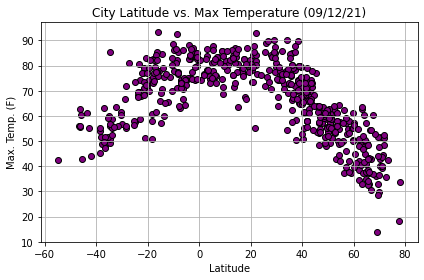

In [9]:
# Latitude vs. Temperature Plot
ylbl = "Max. Temp. (F)"
save_graph = "Lat_Temp.png"
title = "City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_scatter(max_temp, ylbl, title, save_graph)

## Latitude vs. Humidity Plot

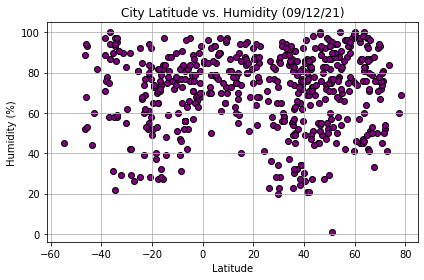

In [10]:
# Latitude vs. Humidity Plot
ylbl = "Humidity (%)"
save_graph = "Lat_Humid.png"
title = "City Latitude vs. Humidity (%s)" % time.strftime("%x")
plot_scatter(humidity, ylbl, title, save_graph)

## Latitude vs. Cloudiness Plot

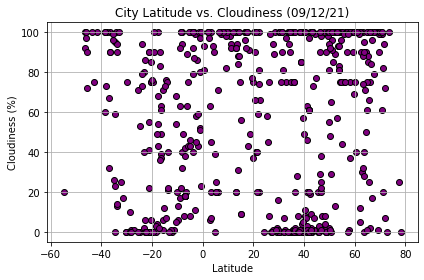

In [11]:
# Latitude vs. Cloudiness Plot
ylbl = "Cloudiness (%)"
save_graph = "Lat_Cloud.png"
title = "City Latitude vs. Cloudiness (%s)" % time.strftime("%x")
plot_scatter(cloudiness, ylbl, title, save_graph)

## Latitude vs. Wind Speed Plot

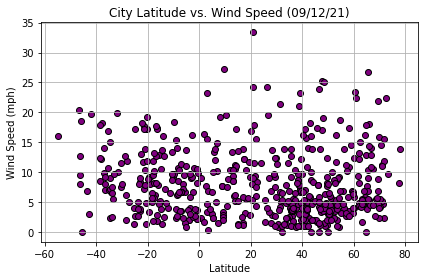

In [12]:
#Latitude vs. Wind Speed Plot
ylbl = "Wind Speed (mph)"
save_graph = "Lat_Wind.png"
title = "City Latitude vs. Wind Speed (%s)" % time.strftime("%x")
plot_scatter(wind_speed, ylbl, title, save_graph)

## Linear Regression

In [13]:
# Create Northern Hemisphere DataFrames
northern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] > 0.0]
northern_hemisphere.reset_index(inplace = True)

# Create Southern Hemisphere DataFrames
southern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] < 0.0]
southern_hemisphere.reset_index(inplace = True)

print(northern_hemisphere.head())
print(southern_hemisphere.head())

   index       City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      0  Upernavik  72.7868  -56.1549     35.78        41           0   
1      1     Barrow  71.2906 -156.7887     44.62        76          20   
2      2        Mar  43.4002   -4.0094     65.01        98         100   
3      3    Gulmarg  34.0490   74.3921     54.37        84          94   
4      4   Guerrero  17.6667 -100.0000     67.69        95         100   

   Wind Speed Country        Date  
0       22.39      GL  1631414830  
1        4.61      US  1631414804  
2        0.00      ES  1631414831  
3        1.16      IN  1631414832  
4        3.22      MX  1631414833  
   index        City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      9  Townsville -19.2500  146.8000     74.28        73          90   
1     13  Kaitangata -46.2817  169.8464     62.74        52          92   
2     15     Rikitea -23.1203 -134.9692     74.25        74          80   
3     17     Kavieng  -2.5744  150.7967

In [14]:
# Create variables for relevant table columns
nlat = northern_hemisphere["Lat"]
nmax_temp = northern_hemisphere["Max Temp"]
nhumidity = northern_hemisphere["Humidity"]
ncloudiness = northern_hemisphere["Cloudiness"]
nwind_speed = northern_hemisphere["Wind Speed"]

slat = southern_hemisphere["Lat"]
smax_temp = southern_hemisphere["Max Temp"]
shumidity = southern_hemisphere["Humidity"]
scloudiness = southern_hemisphere["Cloudiness"]
swind_speed = southern_hemisphere["Wind Speed"]

In [15]:
# Define plotting function
def plot_linear_regression(xdata, ydata, ylbl, lblpos, title, save_graph):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    color = "orange"
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    plt.scatter(xdata, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.plot(xdata,regress_values, color)
    plt.annotate(line_eq, lblpos, fontsize = 15, color = color)
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(ylbl)
    plt.tight_layout()
    plt.savefig("../output_files/" + save_graph)

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.8323785293364219


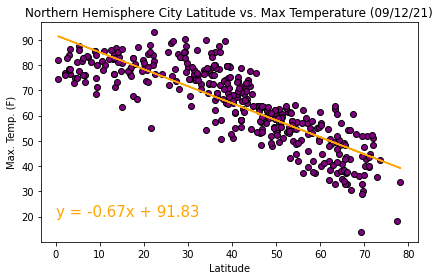

In [16]:
# Create Scatter Plot for Northern Hemisphere - Max Temp vs. Latitude Linear Regression
# And save graph as PNG
ylbl = "Max. Temp. (F)"
lblpos = (0, 20)
save_graph = "NLat_Temp.png"
title = "Northern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nmax_temp, ylbl, lblpos, title, save_graph)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.73987320273305


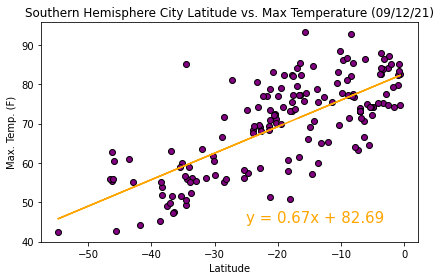

In [24]:
# Create Scatter Plot for Southern Hemisphere - Max Temp vs. Latitude Linear Regression
ylbl = "Max. Temp. (F)"
lblpos = (-25, 45)
save_graph = "SLat_Temp.png"
title = "Southern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(slat, smax_temp, ylbl, lblpos, title, save_graph)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: -0.04975479296028207


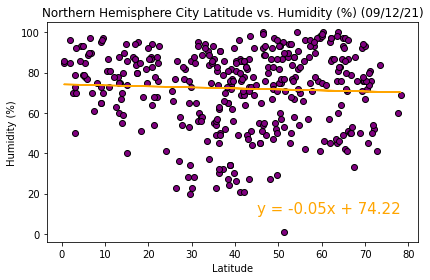

In [18]:
# Create Scatter Plot for Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (45, 10)
save_graph = "NLat_Humid"
title = "Northern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nhumidity, ylbl, lblpos, title, save_graph)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: -0.013263675139386956


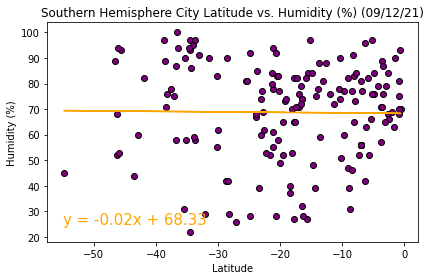

In [19]:
# Create Scatter Plot for Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (-55, 25)
save_graph = "SLat_Humid"
title = "Southern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, shumidity, ylbl, lblpos, title, save_graph)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.03446784365340152


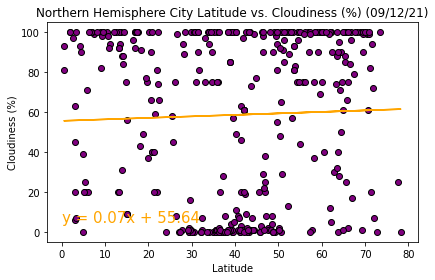

In [20]:
# Create Scatter Plot for Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (0, 5)
save_graph = "NLat_Cloud"
title = "Northern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, ncloudiness, ylbl, lblpos, title, save_graph)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: -0.12435312798074008


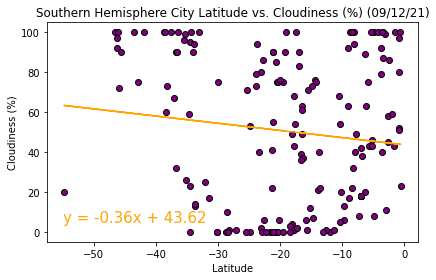

In [21]:
# Create Scatter Plot for Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (-55, 5)
save_graph = "SLat_Cloud"
title = "Southern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, scloudiness, ylbl, lblpos, title, save_graph)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.009089313690219971


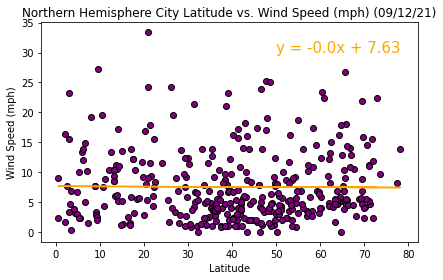

In [22]:
# Create Scatter Plot for Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (50, 30)
save_graph = "NLat_Wind"
title = "Northern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nwind_speed, ylbl, lblpos, title, save_graph)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.2793400333738677


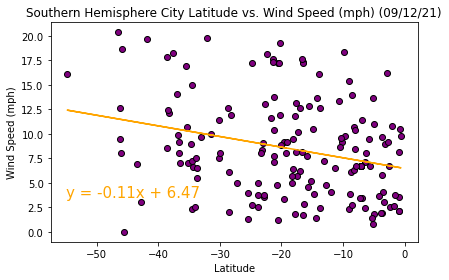

In [33]:
# Create Scatter Plot for Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (-55, 3.5)
save_graph = "SLat_Wind"
title = "Southern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(slat, swind_speed, ylbl, lblpos, title, save_graph)